<a href="https://colab.research.google.com/github/mborkhat/MTech_AI/blob/main/CW/20230903_lab_6_mtech_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.

# Data Preparation
- Create a dataframe containing the meta data
- Create a list of all combinations given in the specification
- Filter out the data using these combinations
- Assign classes to each record (happy or sad)
- Assign gender class to each record so that it can be leveraged during analysis

In [ ]:
records = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        records.append([filename, os.path.join(dirname,filename)])

data = pd.DataFrame(records, columns=['filename','path'])
data['actor'] = data['path'].apply(lambda x: re.findall("\w+_\d+",x)[0])
data = data[data['actor']!="audio_speech_actors_01"]
data.reset_index(inplace=True,drop=True)
data['type'] = data['filename'].apply(lambda x: re.split("-\d+\.wav",x)[0])
data

Empty DataFrame
Columns: [filename, path, actor, type]
Index: []

In [ ]:
data['actor'].nunique()

24

In [ ]:
data['actor'].value_counts()

Actor_02    60
Actor_17    60
Actor_18    60
Actor_13    60
Actor_03    60
Actor_14    60
Actor_09    60
Actor_10    60
Actor_19    60
Actor_04    60
Actor_22    60
Actor_24    60
Actor_23    60
Actor_12    60
Actor_06    60
Actor_15    60
Actor_08    60
Actor_20    60
Actor_11    60
Actor_01    60
Actor_21    60
Actor_16    60
Actor_05    60
Actor_07    60
Name: actor, dtype: int64

In [ ]:
filter_list = []
for a in ["03","04"]:
    for b in ["01","02"]:
        for c in ["01","02"]:
            for d in ["01","02"]:
                filter_list.append(f"03-01-{a}-{b}-{c}-{d}")

data = data[data['type'].isin(filter_list)]
data.reset_index(inplace=True,drop=True)
data['class'] = data['type'].apply(lambda x: 'happy' if x.startswith('03-01-03') else 'sad')
data['gender'] = data['actor'].apply(lambda x: 'female' if int(x.split('_')[1])%2==0 else 'male')

In [ ]:
data

filename  \
0    03-01-04-01-02-01-02.wav   
1    03-01-03-01-01-01-02.wav   
2    03-01-03-01-01-02-02.wav   
3    03-01-04-02-02-02-02.wav   
4    03-01-03-02-01-02-02.wav   
..                        ...   
379  03-01-04-02-02-01-07.wav   
380  03-01-04-01-01-01-07.wav   
381  03-01-03-01-01-02-07.wav   
382  03-01-03-01-02-01-07.wav   
383  03-01-04-02-01-01-07.wav   

                                                  path     actor  \
0    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
1    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
2    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
3    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
4    /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_02   
..                                                 ...       ...   
379  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
380  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
381  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
382  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   
383  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_07   

                  type  class  gender  
0    03-01-04-01-02-01    sad  female  
1    03-01-03-01-01-01  happy  female  
2    03-01-03-01-01-02  happy  female  
3    03-01-04-02-02-02    sad  female  
4    03-01-03-02-01-02  happy  female  
..                 ...    ...     ...  
379  03-01-04-02-02-01    sad    male  
380  03-01-04-01-01-01    sad    male  
381  03-01-03-01-01-02  happy    male  
382  03-01-03-01-02-01  happy    male  
383  03-01-04-02-01-01    sad    male  

[384 rows x 6 columns]

In [ ]:
data['gender'].value_counts()

female    192
male      192
Name: gender, dtype: int64

In [ ]:
data['class'].value_counts()

sad      192
happy    192
Name: class, dtype: int64

In [ ]:
data.loc[1,'filename'] in filter_list

False

In [ ]:
def show_waveplot(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: {name}, Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram: {name}, Class: {label}, Gender: {gender}")

def show_zcr(audio_path,name,label,gender):
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate: {name}, Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,name,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()

def show_spectral_rolloff(audio_path,name,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()

def show_mfccs(audio_path,name,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC: {name}, Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

# Data Analysis and Visualization (Q1)

In [ ]:
happy_df = data[data['class']=='happy'].sample(3)
happy_df

filename  \
57   03-01-03-01-01-02-16.wav   
88   03-01-03-02-02-02-01.wav   
198  03-01-03-02-02-02-23.wav   

                                                  path     actor  \
57   /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_16   
88   /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_01   
198  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_23   

                  type  class  gender  
57   03-01-03-01-01-02  happy  female  
88   03-01-03-02-02-02  happy    male  
198  03-01-03-02-02-02  happy    male

In [ ]:
sad_df = data[data['class']=='sad'].sample(3)
sad_df

filename  \
270  03-01-04-02-02-01-19.wav   
190  03-01-04-01-01-02-12.wav   
240  03-01-04-01-02-02-04.wav   

                                                  path     actor  \
270  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_19   
190  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_12   
240  /kaggle/input/ravdess-emotional-speech-audio/A...  Actor_04   

                  type class  gender  
270  03-01-04-02-02-01   sad    male  
190  03-01-04-01-01-02   sad  female  
240  03-01-04-01-02-02   sad  female

# Audio

## Happy Emotion

In [ ]:
ipd.Audio(happy_df.iloc[0].path)

In [ ]:
ipd.Audio(happy_df.iloc[1].path)

In [ ]:
ipd.Audio(happy_df.iloc[2].path)

## Sad Emotion

In [ ]:
ipd.Audio(sad_df.iloc[0].path)

In [ ]:
ipd.Audio(sad_df.iloc[1].path)

In [ ]:
ipd.Audio(sad_df.iloc[2].path)

# Waveplot

## Happy Emotion
- Happy voice of a female sample has many sharp changes in amplitude while speaking, probably due to change in voice modulation out of speaking with excitement
- A higher amplitude throughout various timesteps in the wave plot is indicative of the fact that people speak more loudly when they are happy or excited
- The difference in sudden spikes in amplitude of male and female can be visibly seen which is an indicator of the difference in pitches of the respective genders

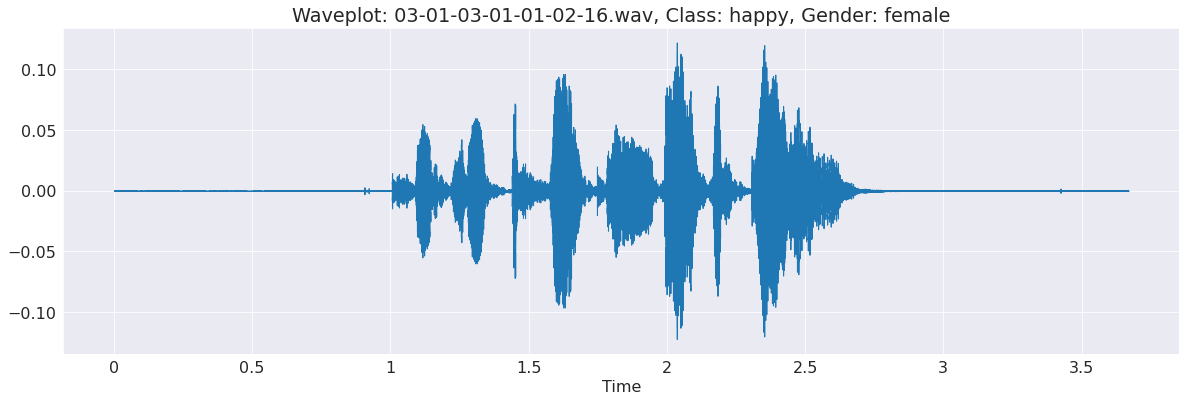

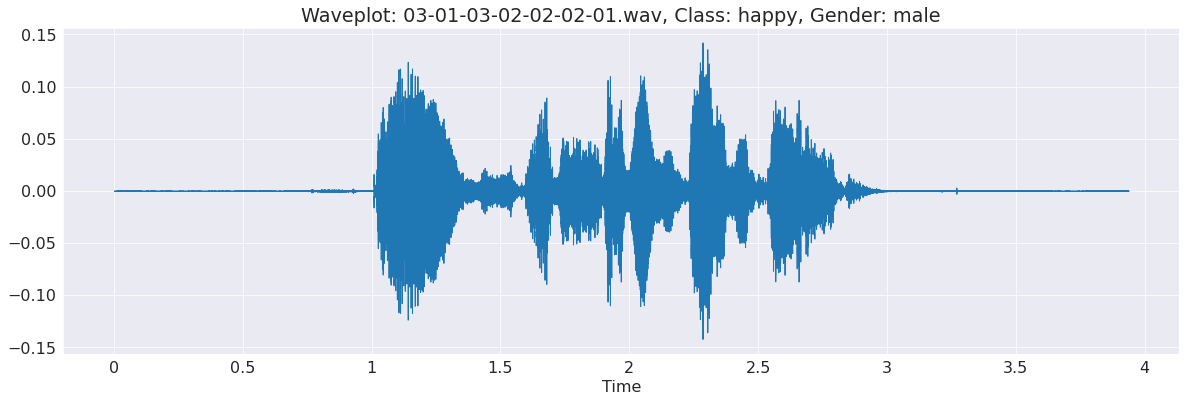

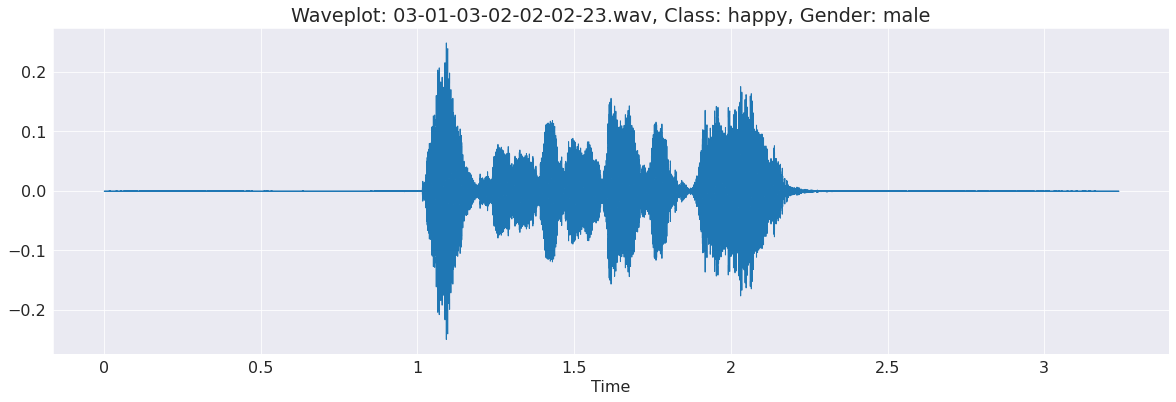

In [ ]:
show_waveplot(happy_df.iloc[0].path,happy_df.iloc[0].filename,'happy',happy_df.iloc[0].gender)
show_waveplot(happy_df.iloc[1].path,happy_df.iloc[1].filename,'happy',happy_df.iloc[1].gender)
show_waveplot(happy_df.iloc[2].path,happy_df.iloc[2].filename,'happy',happy_df.iloc[2].gender)

## Sad Emotion
- Males have a tendency to speak more softly when they are sad and hence it can be seen that the amplitude is quite low of a sad male voice
- Females speak softly and sometimes even have a catch in their throat when overwhelmed with sadness which is noticeable in their pitch and hence the sad female voice can be louder as seen in the 2nd and 3rd plot

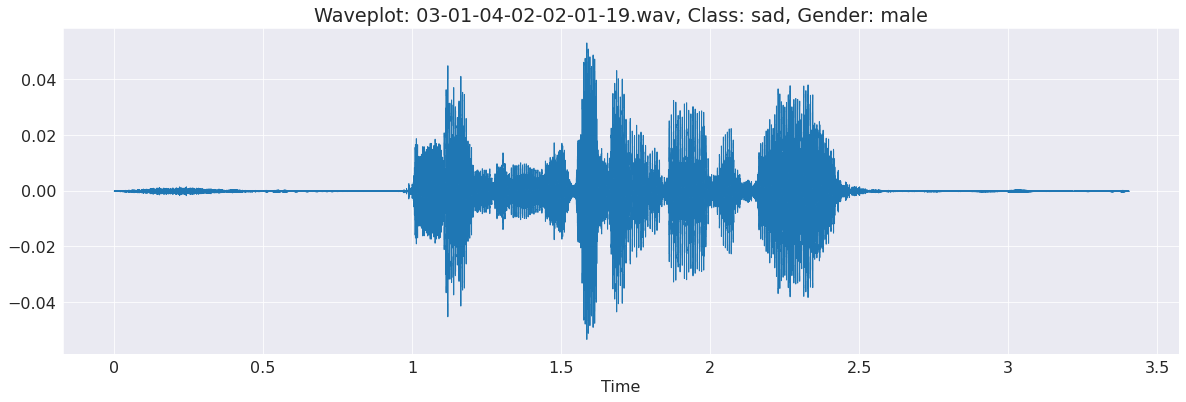

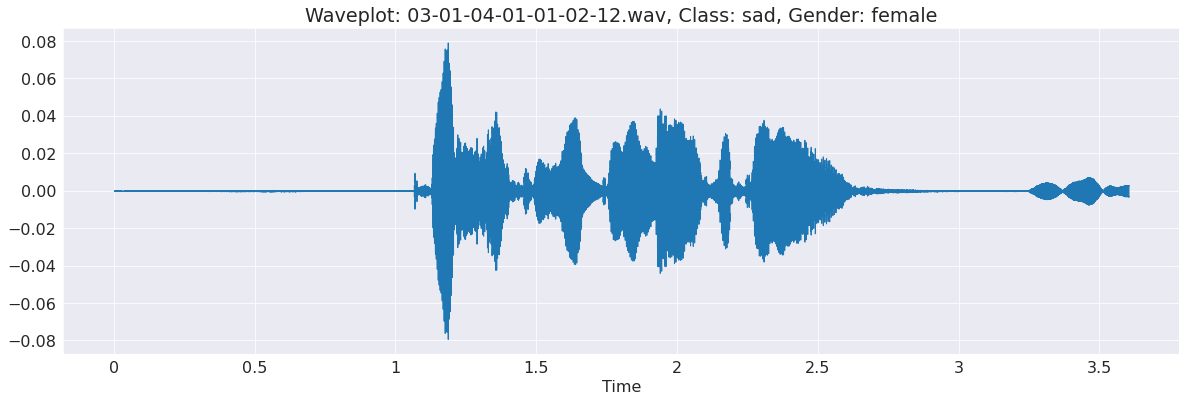

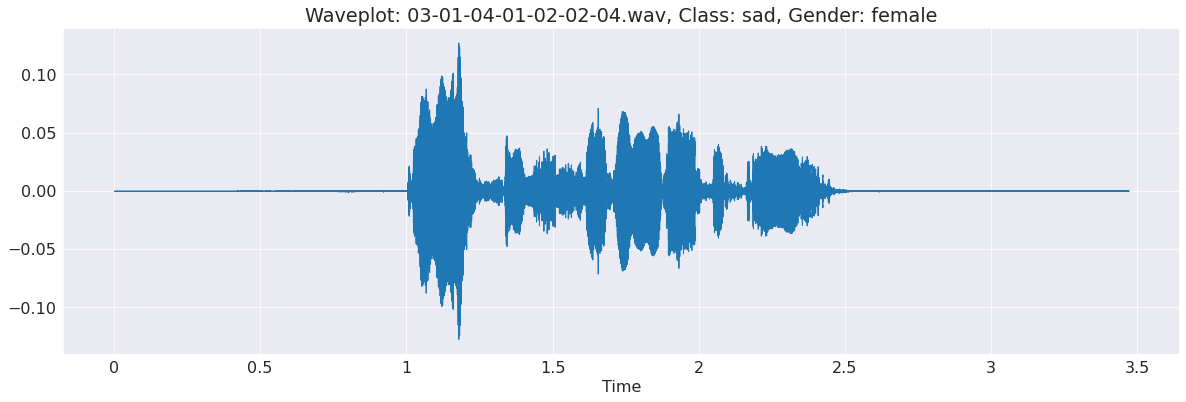

In [ ]:
show_waveplot(sad_df.iloc[0].path,sad_df.iloc[0].filename,'sad',sad_df.iloc[0].gender)
show_waveplot(sad_df.iloc[1].path,sad_df.iloc[1].filename,'sad',sad_df.iloc[1].gender)
show_waveplot(sad_df.iloc[2].path,sad_df.iloc[2].filename,'sad',sad_df.iloc[2].gender)

# Spectrogram

## Happy Emotion
- the spread in magnitude of a frequency of a female voice when she is happy can be seen, most of it is in the range of (0-4kHZ) but due to high pitch of a female voice (4-10kHZ) range also has a slightly higher magnitude
- A happy male's voice which is consistently loud and excited has a more higher magnitude in the (0-4kHZ)

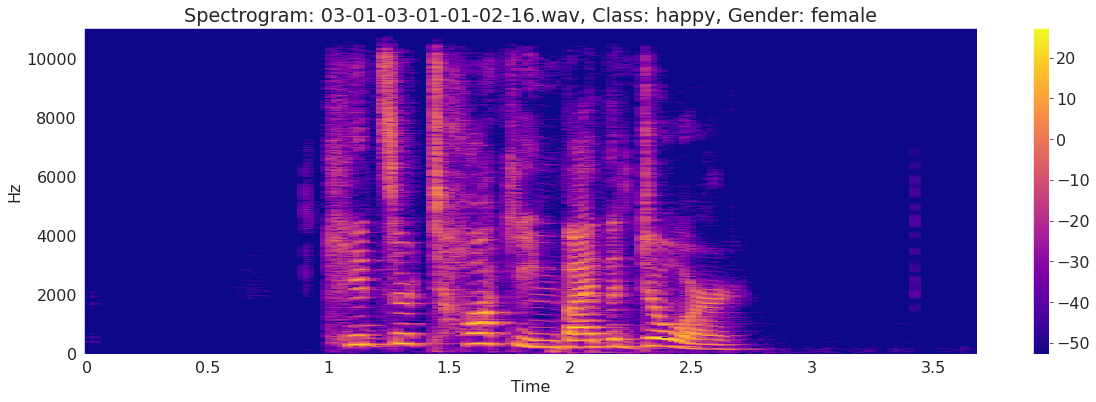

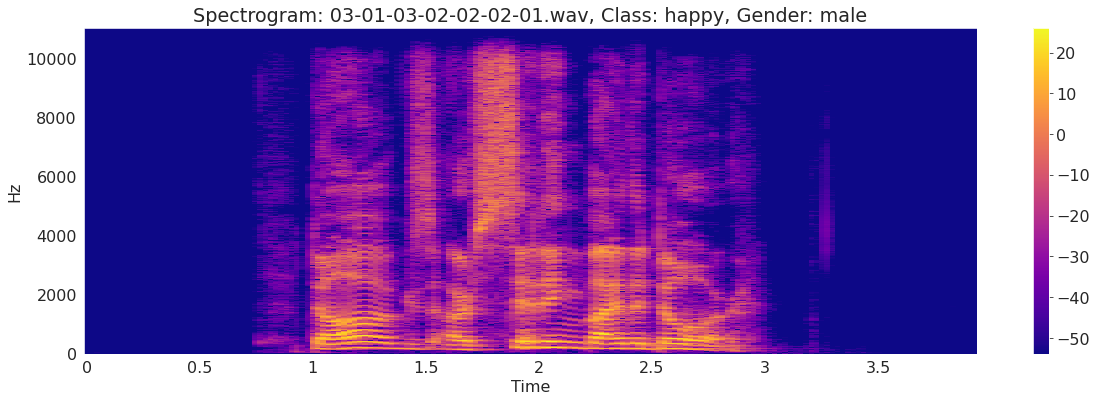

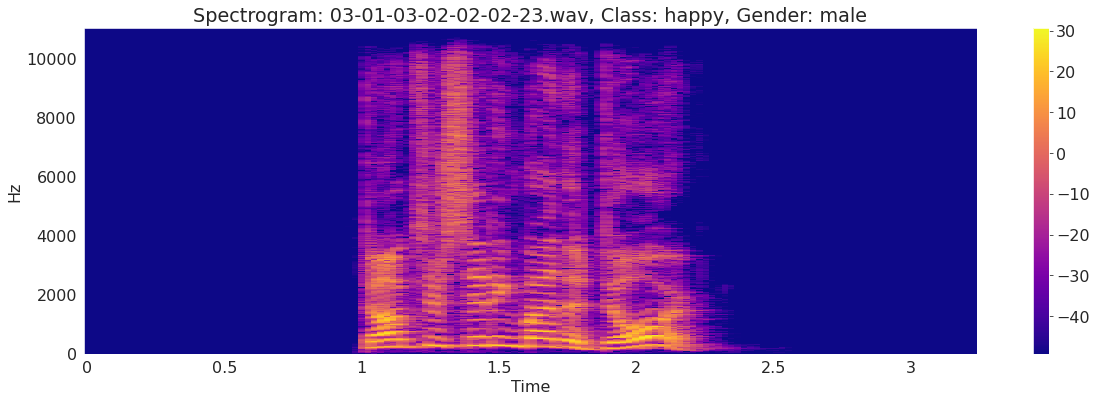

In [ ]:
show_spectrogram(happy_df.iloc[0].path,happy_df.iloc[0].filename,'happy',happy_df.iloc[0].gender)
show_spectrogram(happy_df.iloc[1].path,happy_df.iloc[1].filename,'happy',happy_df.iloc[1].gender)
show_spectrogram(happy_df.iloc[2].path,happy_df.iloc[2].filename,'happy',happy_df.iloc[2].gender)

## Sad Emotion

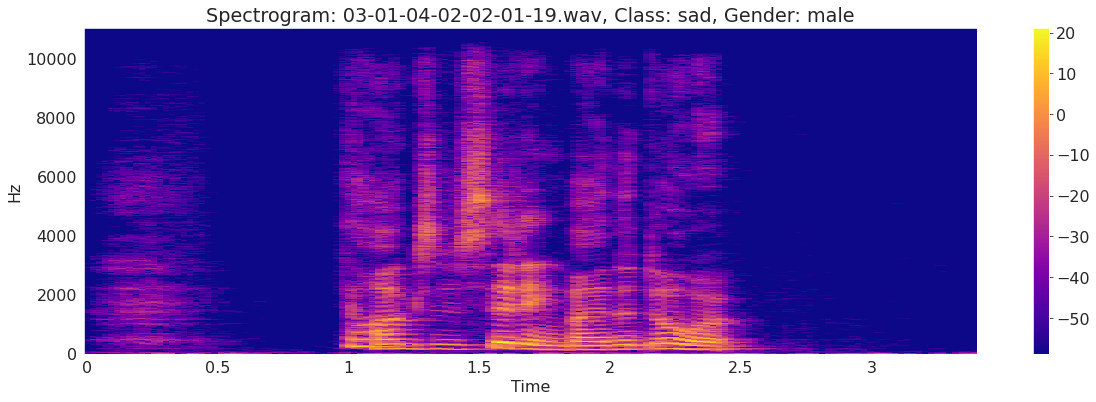

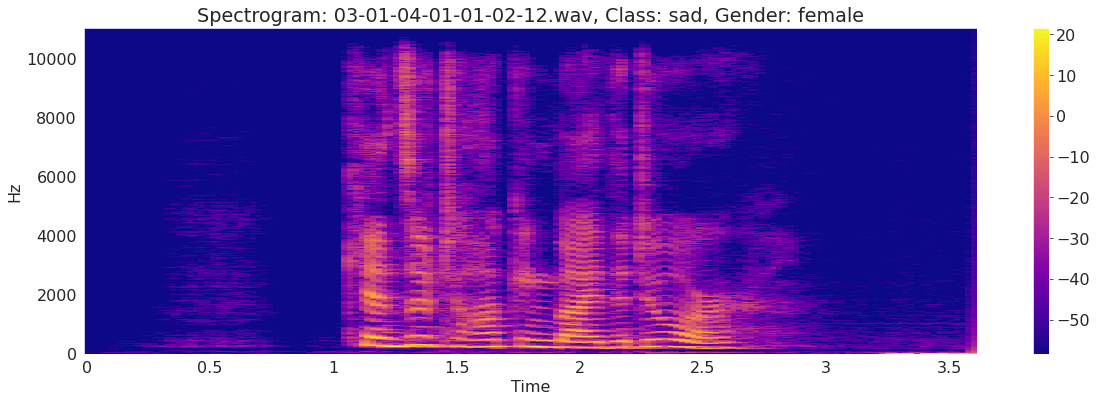

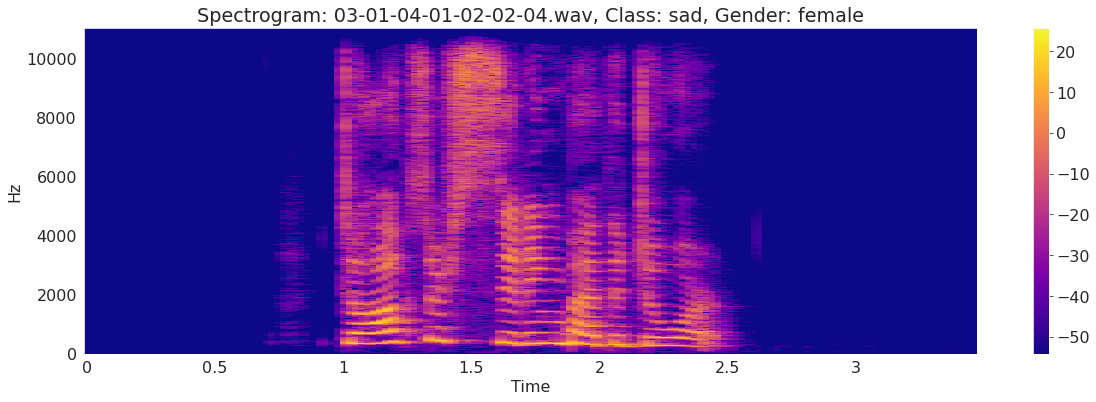

In [ ]:
show_spectrogram(sad_df.iloc[0].path,sad_df.iloc[0].filename,'sad',sad_df.iloc[0].gender)
show_spectrogram(sad_df.iloc[1].path,sad_df.iloc[1].filename,'sad',sad_df.iloc[1].gender)
show_spectrogram(sad_df.iloc[2].path,sad_df.iloc[2].filename,'sad',sad_df.iloc[2].gender)

# Zero Crossings / Zero Crossing Rate

## Happy Emotion
- Happy voices tend to have a higher zero crossing rate than the sad voices due to the loud expression of happiness
- The zero crossing rate increases as some stress is put to make certain words sound louder to express the happiness more evidently

Sum of zero crossing  28244


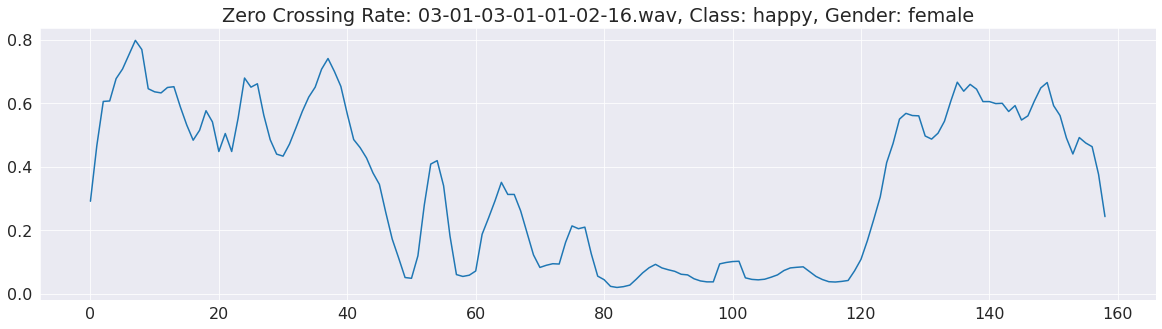

Sum of zero crossing  24977


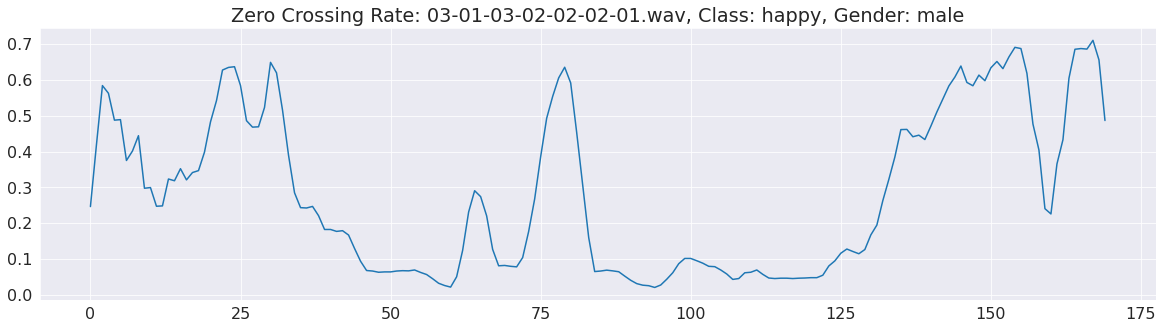

Sum of zero crossing  22599


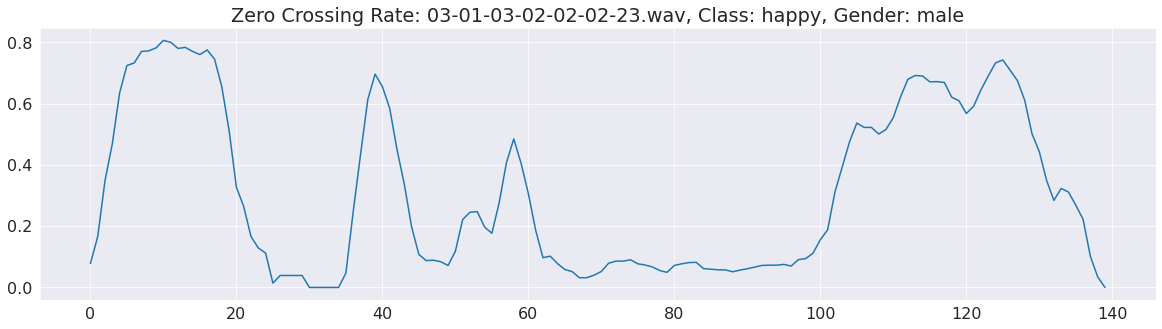

In [ ]:
show_zcr(happy_df.iloc[0].path,happy_df.iloc[0].filename,'happy',happy_df.iloc[0].gender)
show_zcr(happy_df.iloc[1].path,happy_df.iloc[1].filename,'happy',happy_df.iloc[1].gender)
show_zcr(happy_df.iloc[2].path,happy_df.iloc[2].filename,'happy',happy_df.iloc[2].gender)

## Sad Emotion
- Since the change in ZCR is more of an indication of whether a voice maybe present or not, it can be seen that if a person chooses to speak more softly when sad the ZCR will be relatively lower to the the ZCR of a happy voice
- ZCRs in sadness have more continuity i.e. there are no sudden spikes in ZCRs in immediate timesteps

Sum of zero crossing  11277


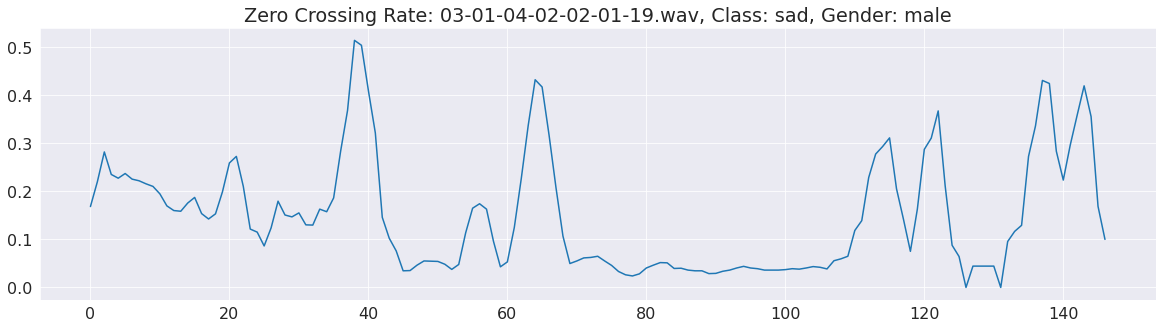

Sum of zero crossing  15710


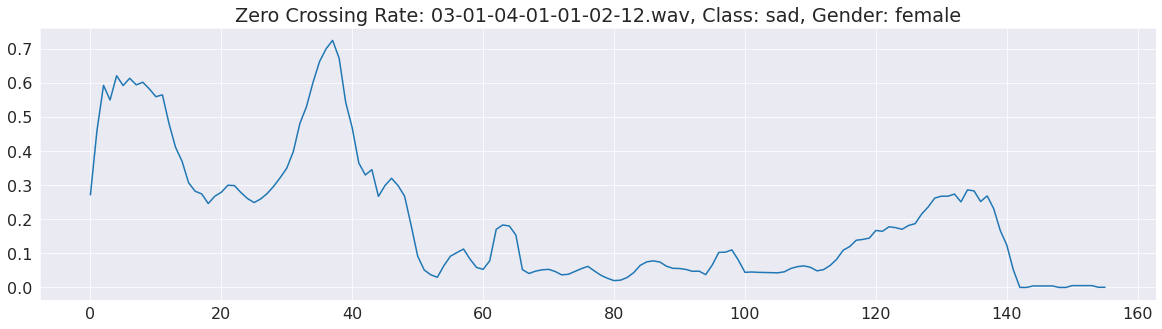

Sum of zero crossing  25783


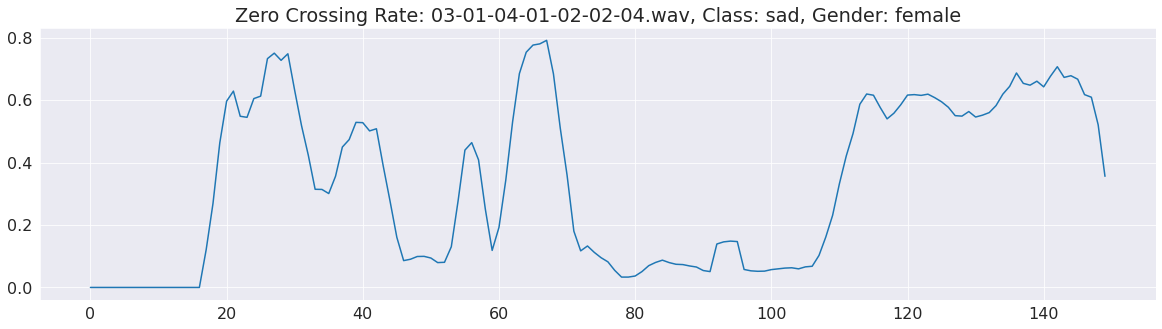

In [ ]:
show_zcr(sad_df.iloc[0].path,sad_df.iloc[0].filename,'sad',sad_df.iloc[0].gender)
show_zcr(sad_df.iloc[1].path,sad_df.iloc[1].filename,'sad',sad_df.iloc[1].gender)
show_zcr(sad_df.iloc[2].path,sad_df.iloc[2].filename,'sad',sad_df.iloc[2].gender)

# Spectral Centroids
- Measures the brightness of a signal, as described by many literature sources (from speech perspective average loudness, brightness is usually described for the images in freq domain)
- It gives the center of gravity of the magnitude spectrum
- It basically gives the frequency band where most of the energy is concentrated
- It is calculated as the weighted mean of frequencies present in the signal.

## Happy Emotion
- Energy becomes high in different spectral areas throughout the audios depending on the way the speaker speaks when he/she is happy

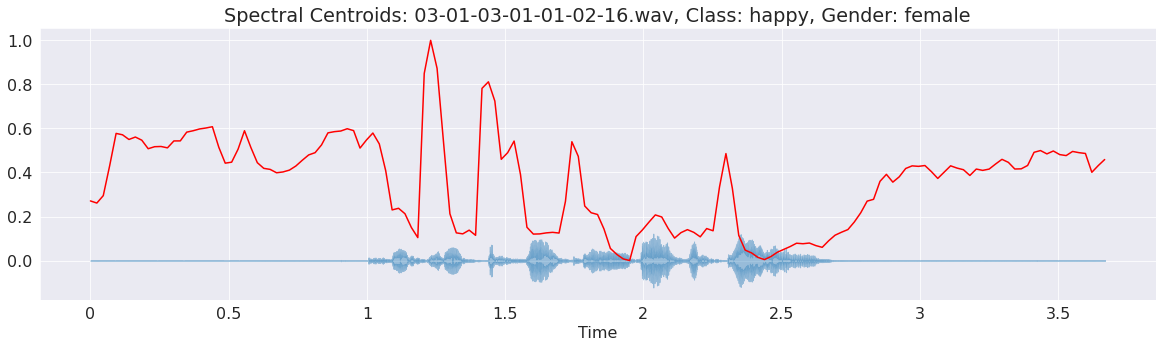

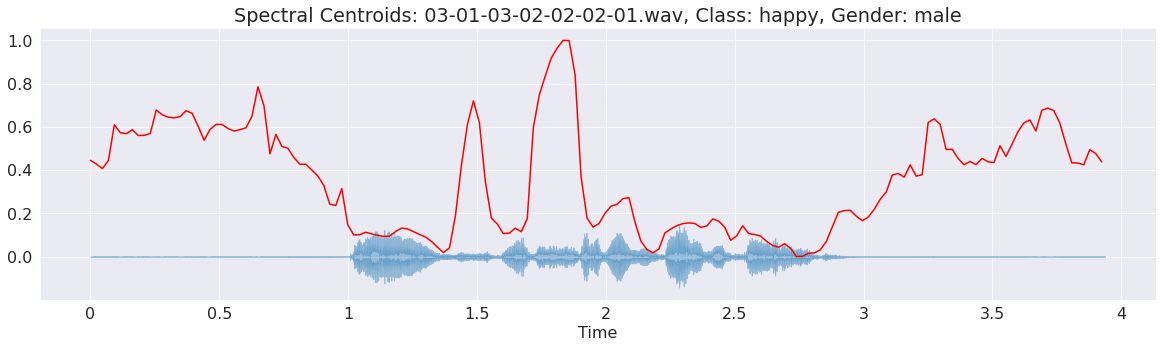

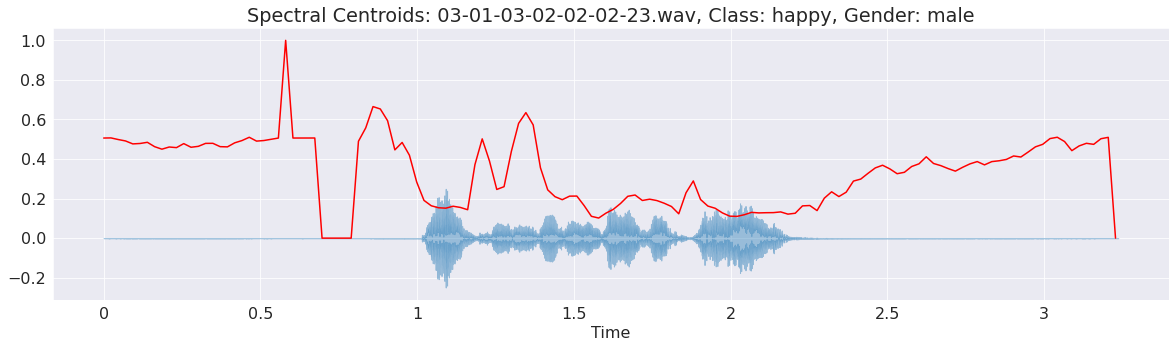

In [ ]:
show_spectral_centroids(happy_df.iloc[0].path,happy_df.iloc[0].filename,'happy',happy_df.iloc[0].gender)
show_spectral_centroids(happy_df.iloc[1].path,happy_df.iloc[1].filename,'happy',happy_df.iloc[1].gender)
show_spectral_centroids(happy_df.iloc[2].path,happy_df.iloc[2].filename,'happy',happy_df.iloc[2].gender)

## Sad Emotion
- In all the spectral centroids of sad emotion you will notice some similar patterns indicating a some similarity in tone quality when a person is sad

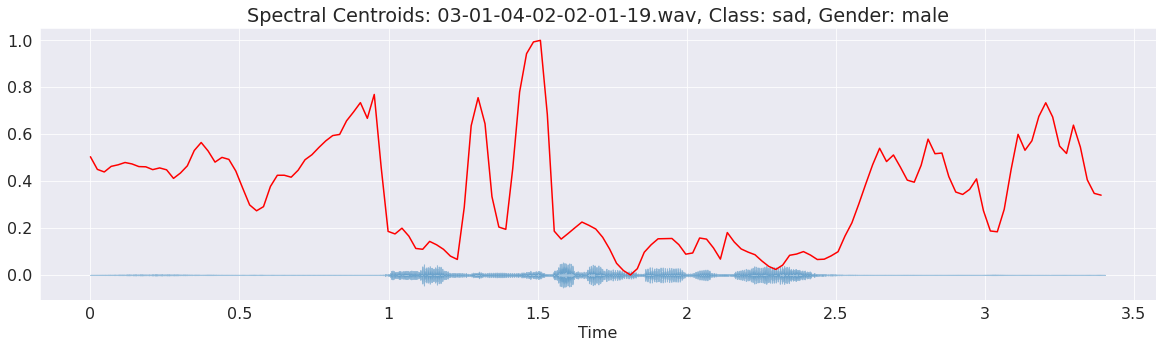

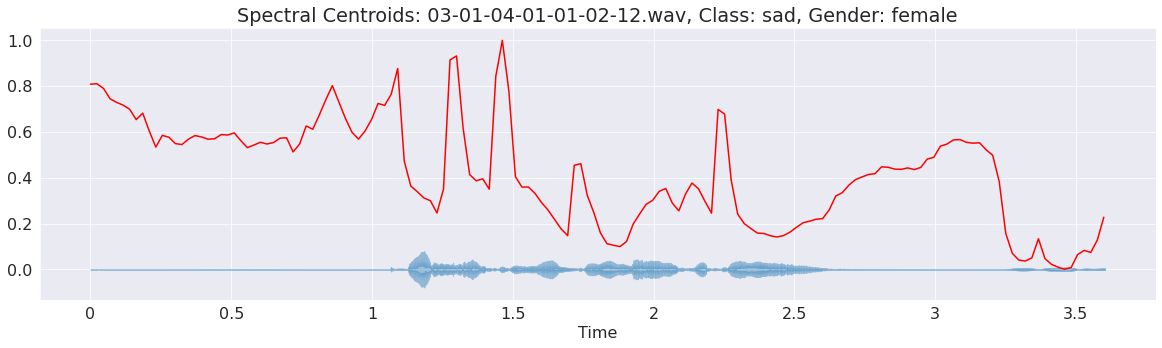

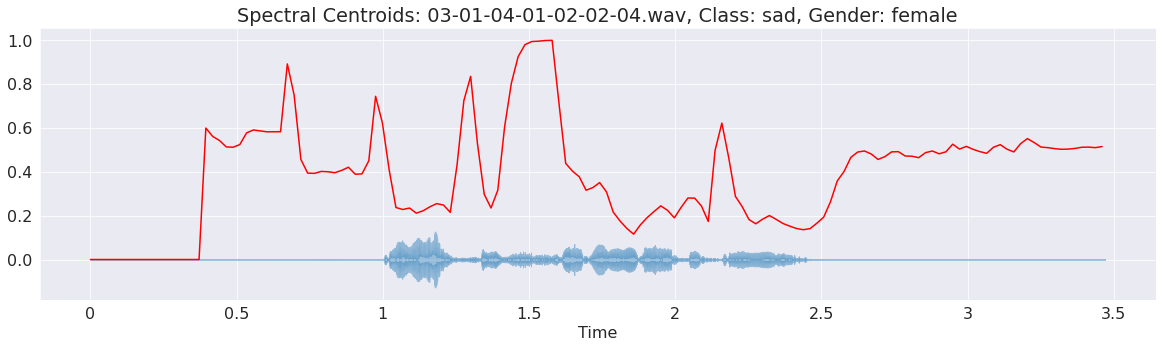

In [ ]:
show_spectral_centroids(sad_df.iloc[0].path,sad_df.iloc[0].filename,'sad',sad_df.iloc[0].gender)
show_spectral_centroids(sad_df.iloc[1].path,sad_df.iloc[1].filename,'sad',sad_df.iloc[1].gender)
show_spectral_centroids(sad_df.iloc[2].path,sad_df.iloc[2].filename,'sad',sad_df.iloc[2].gender)

# Spectral Rolloff
- Spectral rolloff is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

## Happy Emotion
- 85% (default roll off %) of the total spectral energy in happy audios are relatively lower than sad audios, with only occasional sudden spikes

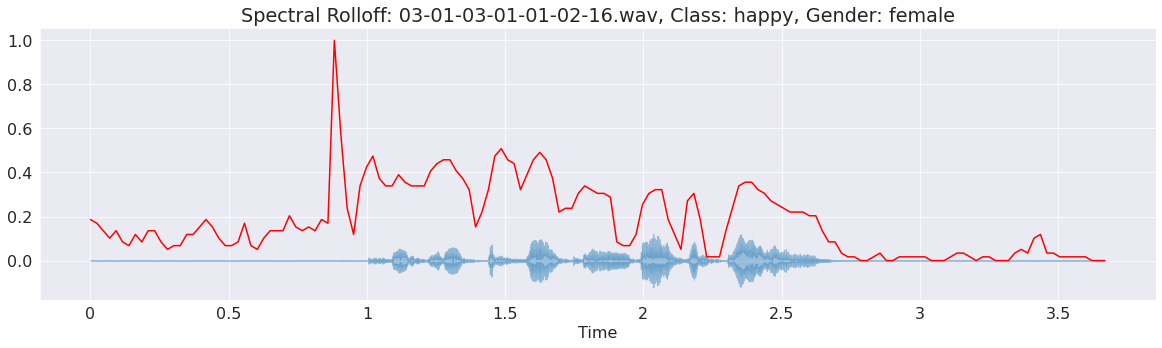

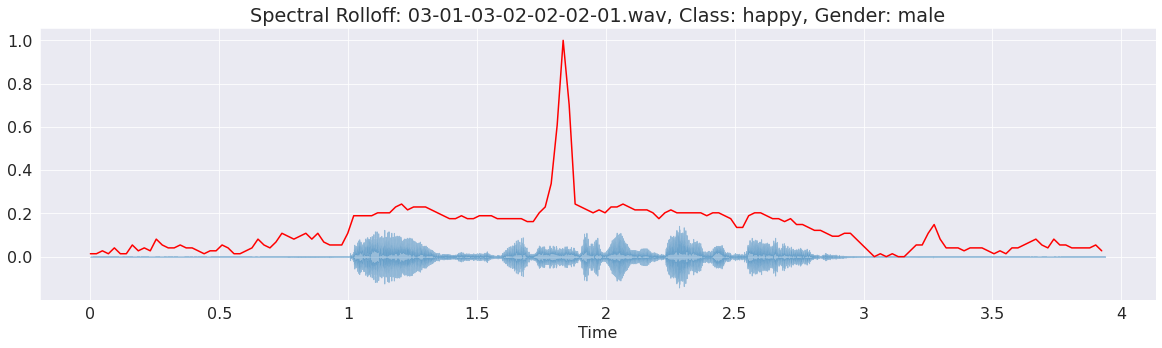

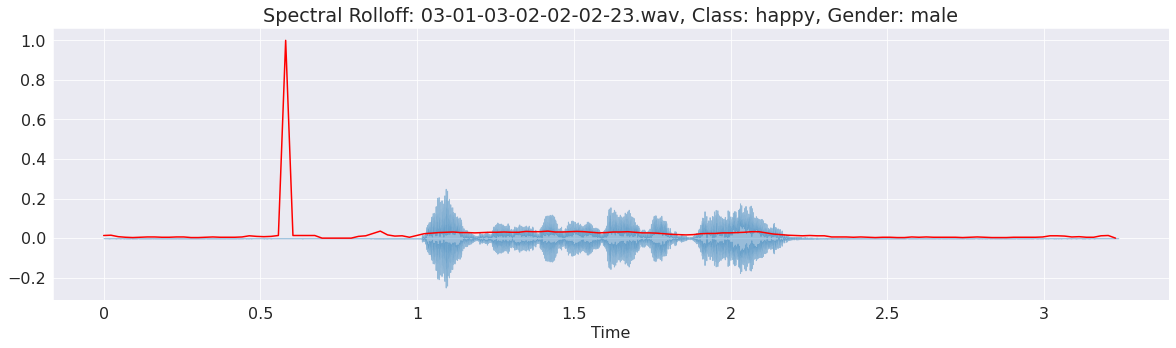

In [ ]:
show_spectral_rolloff(happy_df.iloc[0].path,happy_df.iloc[0].filename,'happy',happy_df.iloc[0].gender)
show_spectral_rolloff(happy_df.iloc[1].path,happy_df.iloc[1].filename,'happy',happy_df.iloc[1].gender)
show_spectral_rolloff(happy_df.iloc[2].path,happy_df.iloc[2].filename,'happy',happy_df.iloc[2].gender)

## Sad Emotion
- 85% (default roll off %) of the total spectral energy in sad audios are relatively higher than happy audios, with little more consistency and occasional drops

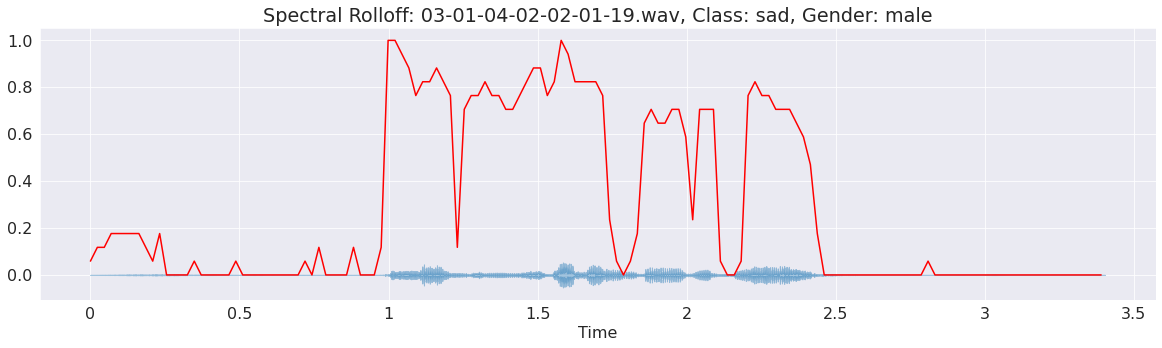

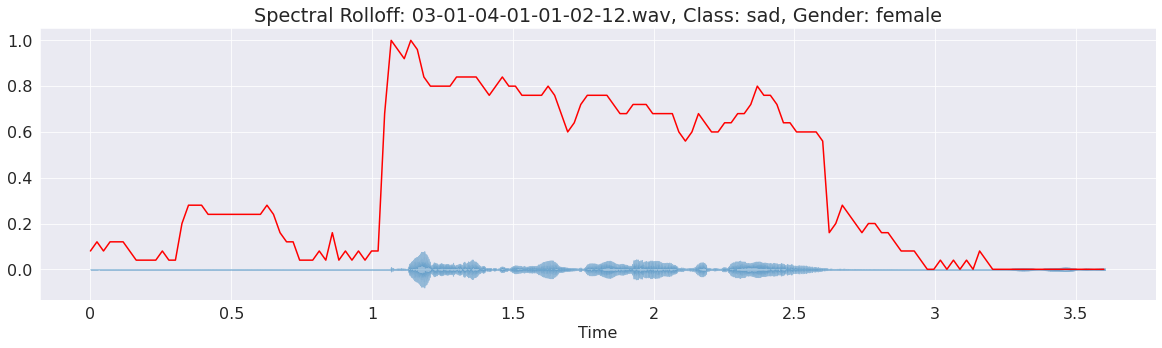

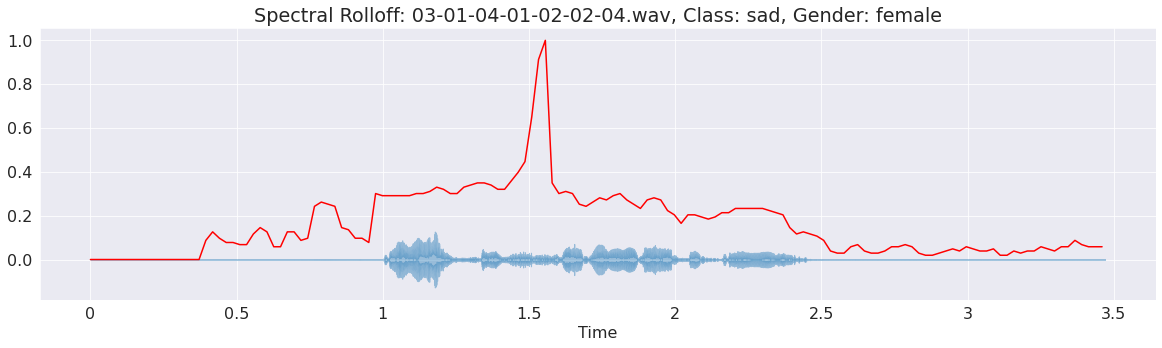

In [ ]:
show_spectral_rolloff(sad_df.iloc[0].path,sad_df.iloc[0].filename,'sad',sad_df.iloc[0].gender)
show_spectral_rolloff(sad_df.iloc[1].path,sad_df.iloc[1].filename,'sad',sad_df.iloc[1].gender)
show_spectral_rolloff(sad_df.iloc[2].path,sad_df.iloc[2].filename,'sad',sad_df.iloc[2].gender)

# MFCCs
- The Mel Scale is a logarithmic transformation of a signal’s frequency. The core idea of this transformation is that sounds of equal distance on the Mel Scale are perceived to be of equal distance to humans
- The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features which concisely describe the overall shape of a spectral envelope
- The MFCC technique aims to develop the features from the audio signal which can be used for detecting the phones in the speech
- The basic procedure to develop MFCCs is the following:
    - Convert from Hertz to Mel Scale
    - Take logarithm of Mel representation of audio
    - Take logarithmic magnitude and use Discrete Cosine Transformation
    - This result creates a spectrum over Mel frequencies as opposed to time, thus creating MFCCs

## Happy

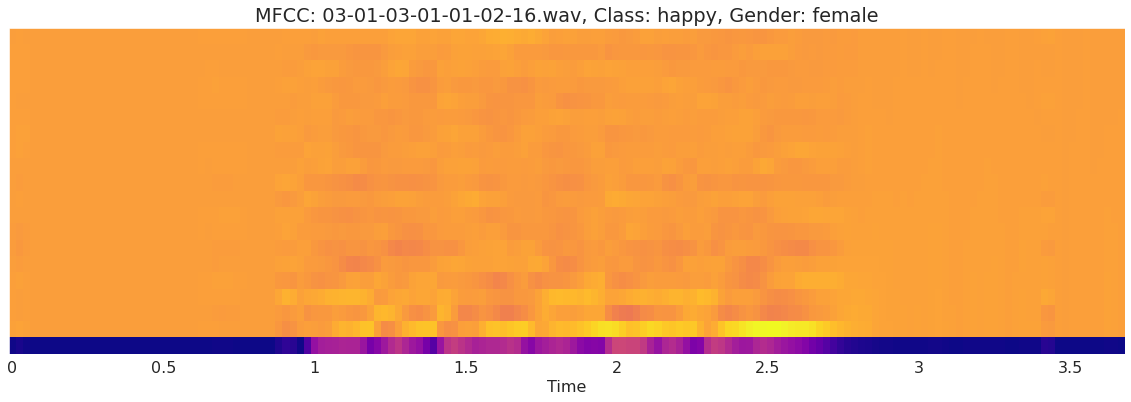

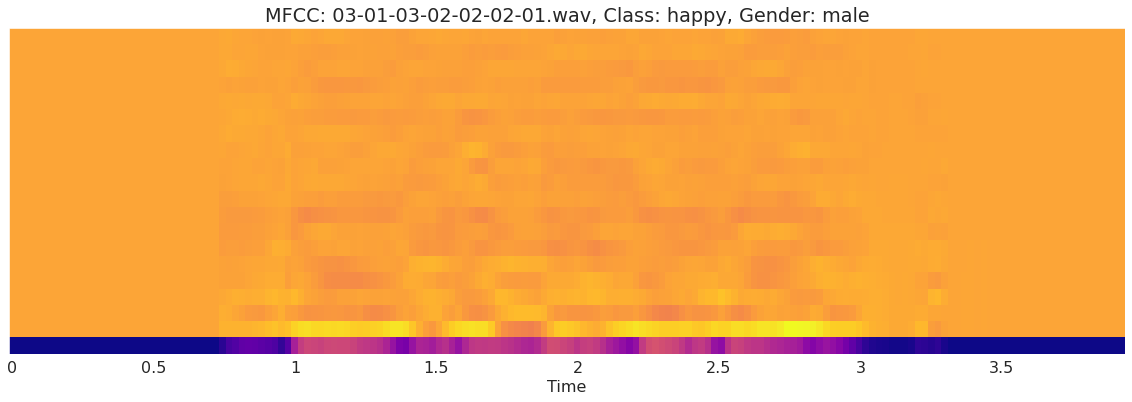

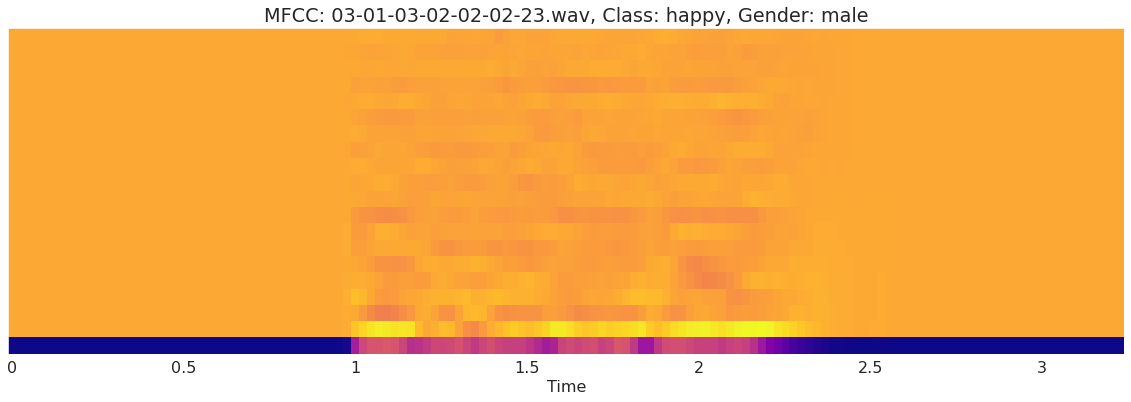

In [ ]:
show_mfccs(happy_df.iloc[0].path,happy_df.iloc[0].filename,'happy',happy_df.iloc[0].gender)
show_mfccs(happy_df.iloc[1].path,happy_df.iloc[1].filename,'happy',happy_df.iloc[1].gender)
show_mfccs(happy_df.iloc[2].path,happy_df.iloc[2].filename,'happy',happy_df.iloc[2].gender)

## Sad

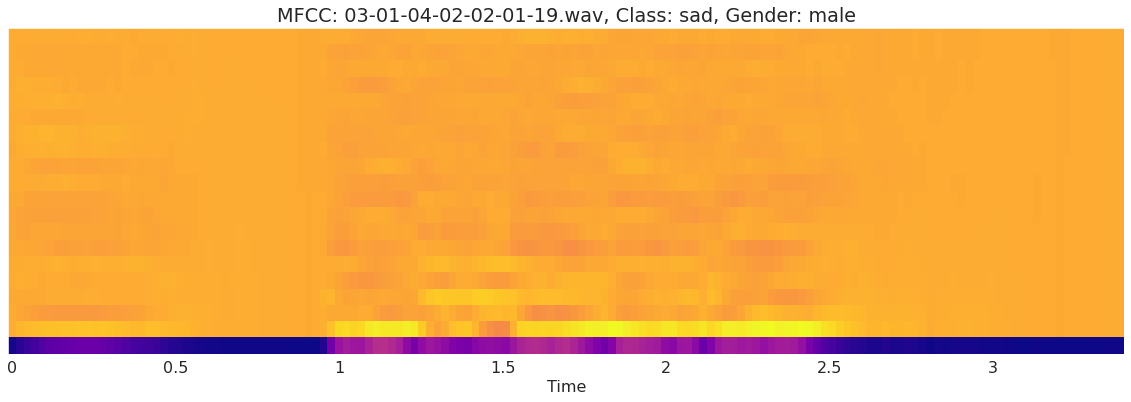

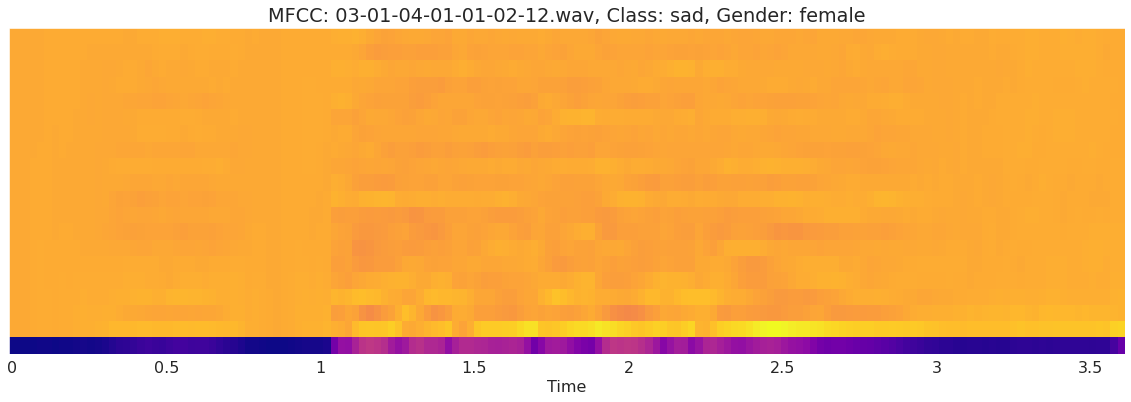

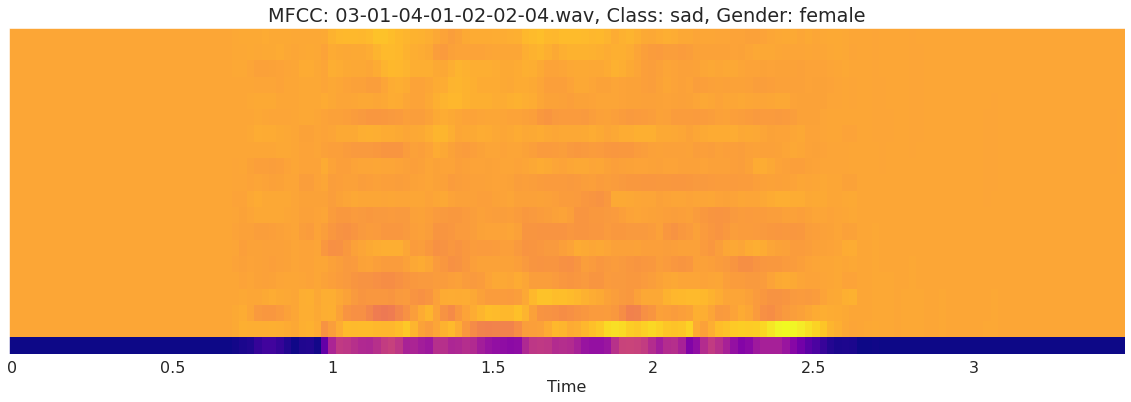

In [ ]:
show_mfccs(sad_df.iloc[0].path,sad_df.iloc[0].filename,'sad',sad_df.iloc[0].gender)
show_mfccs(sad_df.iloc[1].path,sad_df.iloc[1].filename,'sad',sad_df.iloc[1].gender)
show_mfccs(sad_df.iloc[2].path,sad_df.iloc[2].filename,'sad',sad_df.iloc[2].gender)

# Feature Extraction and Modelling (Q2-Q4)

In [ ]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def feature_extraction(df, mfcc=True):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        x , sr = librosa.load(record['path'])
        mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40),axis=1)
        mean_ms = np.mean(librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128),axis=1)
        features.append(mean_mfcc if mfcc else mean_ms)

    dataf = pd.DataFrame(features)
    dataf['class'] = df['class']
    return dataf

## Model 1: MFCC Features

In [ ]:
dataf = feature_extraction(data)
dataf

100%|██████████| 384/384 [02:01<00:00,  3.17it/s]


0          1          2          3          4          5  \
0   -655.887451  44.384995  -5.922089   5.301328  -5.846109  -3.695551   
1   -585.728638  44.487385 -22.599588   9.817188  -8.152647  -4.897211   
2   -605.731567  46.535400 -19.348291  13.490911  -7.866285  -5.181213   
3   -661.506409  45.826687  -8.344815   6.547118  -6.763440  -5.770291   
4   -484.870270  37.232101 -32.120388   7.449310 -10.889060 -14.209931   
..          ...        ...        ...        ...        ...        ...   
379 -568.361694  57.210964   0.689539  12.319594   6.551200  -0.579483   
380 -723.345276  73.582779   0.339823  12.872882   5.823831  -0.428393   
381 -637.680298  78.848206  -7.289741  16.754477   6.813106  -4.355325   
382 -614.372986  73.964455 -10.224572  16.619707   6.027779  -0.498516   
383 -596.720459  75.533997 -10.849150  16.255589  11.882466  -9.690378   

             6          7          8         9  ...        31         32  \
0   -10.138599 -10.529056  -5.311738 -2.087161  ...  8.205554  10.583384   
1    -5.878748 -11.672596  -5.678558 -2.191390  ...  1.049427   1.861293   
2    -5.951238 -11.170672  -4.939478 -2.804853  ...  3.186536   3.086992   
3   -13.880534 -12.418792 -10.221000 -1.434967  ...  2.721710  -0.795996   
4    -9.655680 -12.668373  -6.404204 -4.595531  ...  6.635341   4.776250   
..         ...        ...        ...       ...  ...       ...        ...   
379 -16.130163  -6.567527 -11.981590 -4.644281  ...  6.581381   4.747800   
380  -6.189919  -9.161605  -7.757164 -0.468081  ... -0.812515  -1.119456   
381  -9.541617  -7.217409  -0.118985  0.594490  ...  2.064848  -1.282524   
382 -12.134978  -9.038948  -1.969959  2.583837  ...  2.382087  -0.563464   
383 -18.414713  -6.514667 -19.538132 -7.320460  ...  3.634085   1.559115   

            33        34        35        36        37        38        39  \
0    11.930944  9.304597  6.307230 -1.264757  1.518493  1.149358  2.528079   
1     4.636549  2.063732  0.542157 -2.896340  1.669928  0.835019  0.809699   
2     5.444804  2.192533  2.846328 -1.014606  2.328463 -0.378926  0.160340   
3    -0.365591 -3.481662  0.359042 -3.229184 -1.215640 -3.018485  0.392388   
4     3.537167  1.276880  3.460861  1.100312  4.314916  1.195985  1.496293   
..         ...       ...       ...       ...       ...       ...       ...   
379   8.126586  6.595577  5.743280  4.722243  5.580727  6.205064  6.232939   
380  -0.714403 -1.378729 -1.660836 -3.733672 -0.695816 -1.128454  2.900041   
381  -0.400631 -2.426583 -2.342971 -3.850842 -0.496144  1.623575  4.050527   
382   1.800480  0.647411  2.028122  2.590761  6.235395  7.084024  4.658405   
383   4.331438  2.325002 -0.458636 -0.078974  1.494069  3.380859  3.646428   

     class  
0      sad  
1    happy  
2    happy  
3      sad  
4    happy  
..     ...  
379    sad  
380    sad  
381  happy  
382  happy  
383    sad  

[384 rows x 41 columns]

In [ ]:
X = dataf.iloc[:,:-1]
y = dataf.iloc[:,-1]

### Correlation Heatmap: MFCC Features

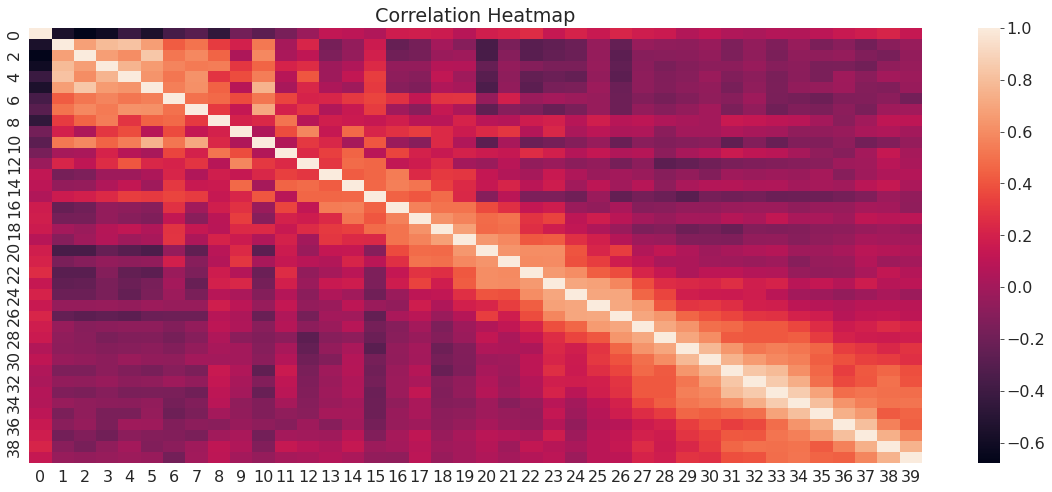

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(X.corr())
plt.title("Correlation Heatmap")
plt.show()

### Descriptive Stats: MFCC Features

In [ ]:
X.describe()

0           1           2           3           4           5   \
count  384.000000  384.000000  384.000000  384.000000  384.000000  384.000000   
mean  -598.043396   51.846508   -8.818723   10.023806    0.278307   -3.112228   
std     91.073402   15.832522   13.126407    7.665812    8.049795    8.114283   
min   -840.468262    6.687021  -53.785812  -12.311014  -19.237770  -23.945635   
25%   -662.914566   42.618118  -15.703305    4.960280   -5.984914   -8.874993   
50%   -606.425354   52.548029   -8.342218   10.101193    0.458414   -2.867631   
75%   -529.973038   63.562356   -0.717991   15.676497    6.821666    2.482767   
max   -351.335632   97.879623   22.820805   30.569365   19.505455   19.156403   

               6           7           8           9   ...          30  \
count  384.000000  384.000000  384.000000  384.000000  ...  384.000000   
mean    -8.135705   -7.895220   -9.420998   -0.337079  ...    0.007180   
std      6.177635    5.313250    4.877603    4.267533  ...    2.689642   
min    -25.613754  -23.455851  -25.333675  -17.983112  ...   -6.343015   
25%    -12.473373  -11.716206  -12.159817   -3.190677  ...   -1.975123   
50%     -8.091770   -7.883519   -9.221408   -0.271101  ...   -0.265453   
75%     -3.494974   -4.070388   -5.783057    2.332246  ...    1.612724   
max     11.021085    6.905970    0.328099   12.858348  ...    9.611135   

               31          32          33          34          35          36  \
count  384.000000  384.000000  384.000000  384.000000  384.000000  384.000000   
mean     2.488577    0.353079    2.589911    0.686422    2.496595    0.323910   
std      3.097333    2.873363    3.084966    2.905427    2.481598    2.266343   
min     -4.057730   -5.289346   -3.492412   -4.776166   -2.772102   -5.320780   
25%      0.468279   -1.626409    0.412221   -1.383294    0.906879   -1.292792   
50%      1.974387   -0.176835    1.879575    0.276971    2.184991    0.136545   
75%      4.132442    1.977686    4.374708    2.391648    4.058426    1.631882   
max     14.817591   11.138241   12.579500   10.566194   11.345574    8.090716   

               37          38          39  
count  384.000000  384.000000  384.000000  
mean     1.300410   -0.327452    1.307867  
std      2.218553    2.221391    2.166801  
min     -4.282027   -4.613907   -3.319401  
25%     -0.227982   -1.973585   -0.296675  
50%      1.179137   -0.659366    1.086867  
75%      2.429541    0.968669    2.734478  
max     10.216620    7.663630   10.596412  

[8 rows x 40 columns]

### Scale: MFCC Features
- since the scale of the features are very different we need to standardize the data before passing it on to our paramterized ML algorithm

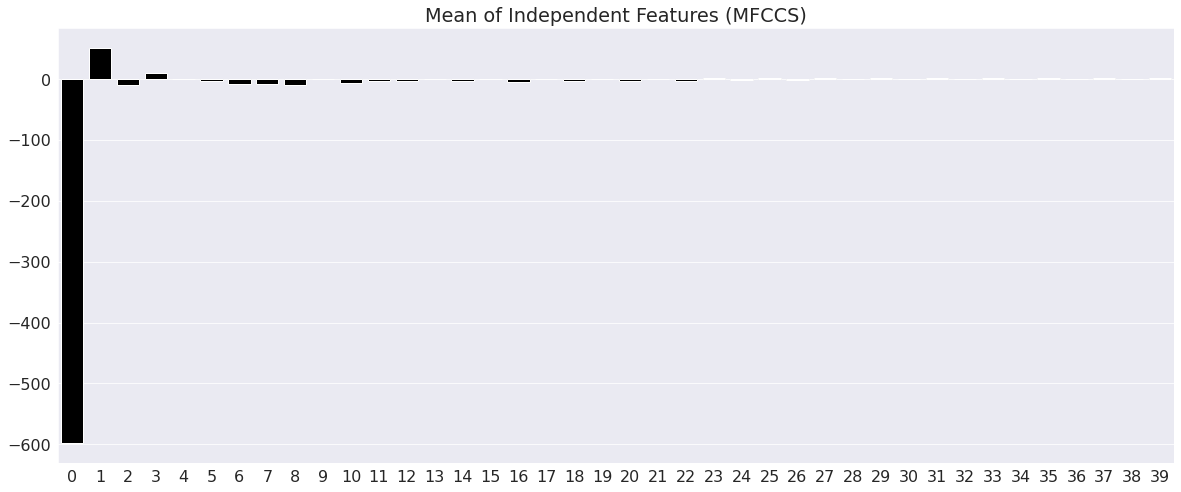

In [ ]:
sns.barplot(x=X.columns,y=X.mean(axis=0),color='black')
plt.title("Mean of Independent Features (MFCCS)")
plt.show()

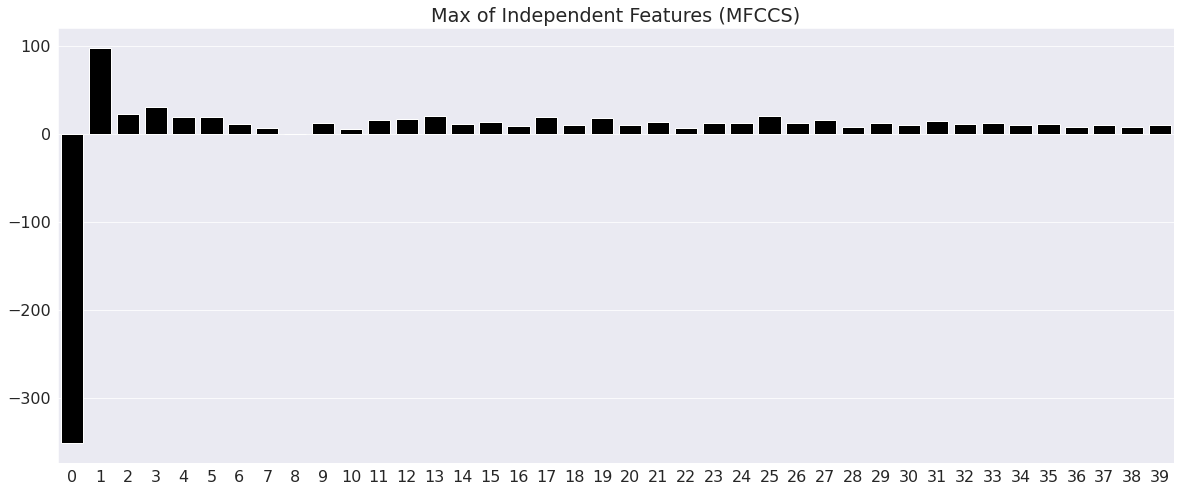

In [ ]:
sns.barplot(x=X.columns,y=X.max(axis=0),color='black')
plt.title("Max of Independent Features (MFCCS)")
plt.show()

In [ ]:
def LogisticRegressionPipeline(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    pipeline = Pipeline([('scaler',StandardScaler()),('LogisticRegression',LogisticRegression())])
    pipeline.fit(X_train,y_train)
    y_train_pred = pipeline.predict(X_train)
    y_pred = pipeline.predict(X_test)

    cmatrix = confusion_matrix(y_test,y_pred)

    print("Training Performance")
    print(classification_report(y_train,y_train_pred))
    print("-----------------------------------------")
    print("Test Performance")
    print(classification_report(y_test,y_pred))
    print("-----------------------------------------")

    cv_score = cross_val_score(pipeline,X,y,cv=5)
    average = lambda x: sum(x)/len(x)
    print("5-Folds Scores: ", cv_score)
    print("-----------------------------------------")
    print("5-Folds Average Score: ",average(cv_score))

    return cv_score, cmatrix

## Model 1: Classification Report

In [ ]:
scores, cmatrix = LogisticRegressionPipeline(X,y)

Training Performance
              precision    recall  f1-score   support

       happy       0.86      0.86      0.86       154
         sad       0.86      0.86      0.86       153

    accuracy                           0.86       307
   macro avg       0.86      0.86      0.86       307
weighted avg       0.86      0.86      0.86       307

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

       happy       0.72      0.68      0.70        38
         sad       0.71      0.74      0.72        39

    accuracy                           0.71        77
   macro avg       0.71      0.71      0.71        77
weighted avg       0.71      0.71      0.71        77

-----------------------------------------
5-Folds Scores:  [0.63636364 0.75324675 0.83116883 0.71428571 0.75      ]
-----------------------------------------
5-Folds Average Score:  0.7370129870129871


<AxesSubplot:>

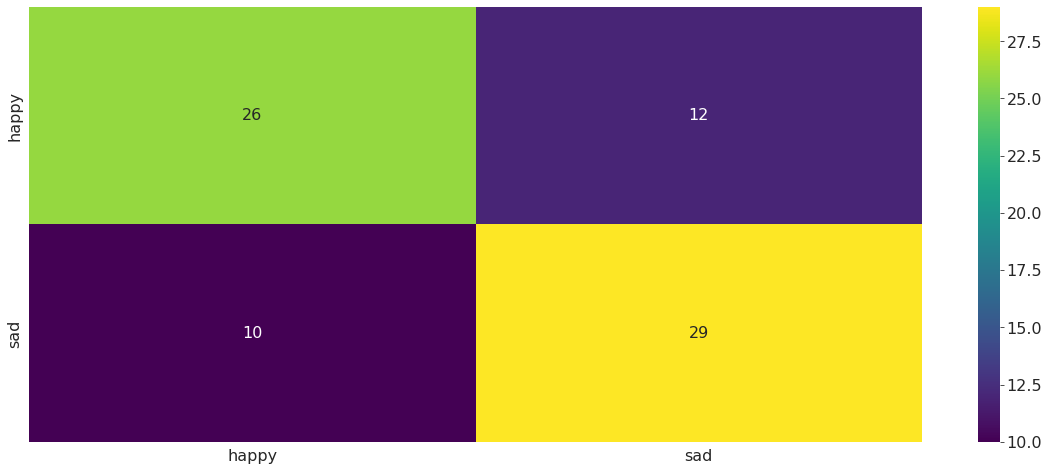

In [ ]:
sns.heatmap(cmatrix,annot=True,fmt='.3g',cmap='viridis',xticklabels=['happy','sad'],yticklabels=['happy','sad'])

## Model Summary
- The performance across the 5 folds are a little inconsistent
- The model performs particularly well on one of the folds (3rd Fold), but not on the others

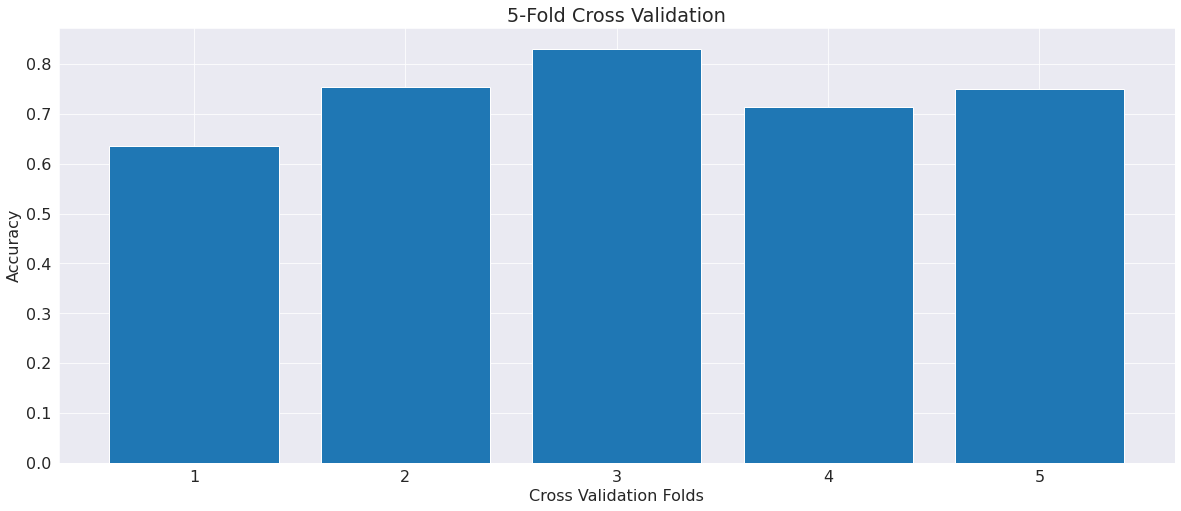

In [ ]:
plt.bar(x=list(range(1,6)),height=scores)
plt.xlabel("Cross Validation Folds")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross Validation")
plt.show()

## Model 2: Mel Spectrogram Features

In [ ]:
dataf = feature_extraction(data,mfcc=False)
dataf

100%|██████████| 384/384 [01:58<00:00,  3.23it/s]


0         1         2         3         4         5         6  \
0    0.000006  0.000004  0.000007  0.000004  0.000004  0.000113  0.010259   
1    0.000010  0.000062  0.000121  0.000124  0.000140  0.002472  0.019177   
2    0.000015  0.000039  0.000191  0.000211  0.000450  0.001405  0.015066   
3    0.000001  0.000003  0.000018  0.000027  0.000068  0.000192  0.000435   
4    0.000100  0.000096  0.000092  0.000068  0.000046  0.000340  0.015523   
..        ...       ...       ...       ...       ...       ...       ...   
379  0.584062  0.000854  0.000105  0.000018  0.000614  0.020639  0.083743   
380  0.000039  0.000011  0.000006  0.000412  0.007097  0.017221  0.015674   
381  0.000367  0.000086  0.002112  0.002465  0.024505  0.084531  0.065262   
382  0.000077  0.000044  0.000832  0.001446  0.004995  0.040185  0.114150   
383  0.000030  0.000009  0.000027  0.000067  0.002824  0.014333  0.026669   

            7         8         9  ...       119       120       121  \
0    0.098932  0.067486  0.040678  ...  0.000055  0.000103  0.000051   
1    0.073552  0.093589  0.154644  ...  0.000048  0.000044  0.000041   
2    0.073748  0.153525  0.073451  ...  0.000050  0.000072  0.000047   
3    0.001680  0.007180  0.101979  ...  0.000110  0.000083  0.000171   
4    0.228503  0.263276  0.121614  ...  0.000364  0.000303  0.000181   
..        ...       ...       ...  ...       ...       ...       ...   
379  0.061423  0.052704  0.012844  ...  0.000343  0.000377  0.000544   
380  0.000889  0.000942  0.005823  ...  0.000002  0.000002  0.000004   
381  0.003117  0.001634  0.011607  ...  0.000003  0.000007  0.000013   
382  0.042320  0.021464  0.004327  ...  0.000027  0.000035  0.000060   
383  0.021353  0.018114  0.012603  ...  0.000022  0.000024  0.000016   

          122       123       124       125           126           127  class  
0    0.000088  0.000059  0.000027  0.000010  5.699148e-07  1.328700e-08    sad  
1    0.000036  0.000020  0.000020  0.000008  5.696950e-07  1.192879e-08  happy  
2    0.000052  0.000026  0.000022  0.000005  4.933853e-07  6.702310e-09  happy  
3    0.000140  0.000173  0.000078  0.000018  6.620907e-07  7.958771e-09    sad  
4    0.000219  0.000268  0.000211  0.000069  1.035260e-05  1.570711e-07  happy  
..        ...       ...       ...       ...           ...           ...    ...  
379  0.000408  0.000355  0.000266  0.000091  7.500727e-06  7.699103e-08    sad  
380  0.000006  0.000007  0.000007  0.000002  1.133628e-07  1.654082e-09    sad  
381  0.000012  0.000009  0.000005  0.000001  1.083808e-07  1.771896e-09  happy  
382  0.000048  0.000041  0.000023  0.000006  5.396259e-07  8.839143e-09  happy  
383  0.000010  0.000017  0.000008  0.000004  2.402338e-07  7.986513e-09    sad  

[384 rows x 129 columns]

In [ ]:
X = dataf.iloc[:,:-1]
y = dataf.iloc[:,-1]

## Correlation Heatmap: Mel Spectro Features

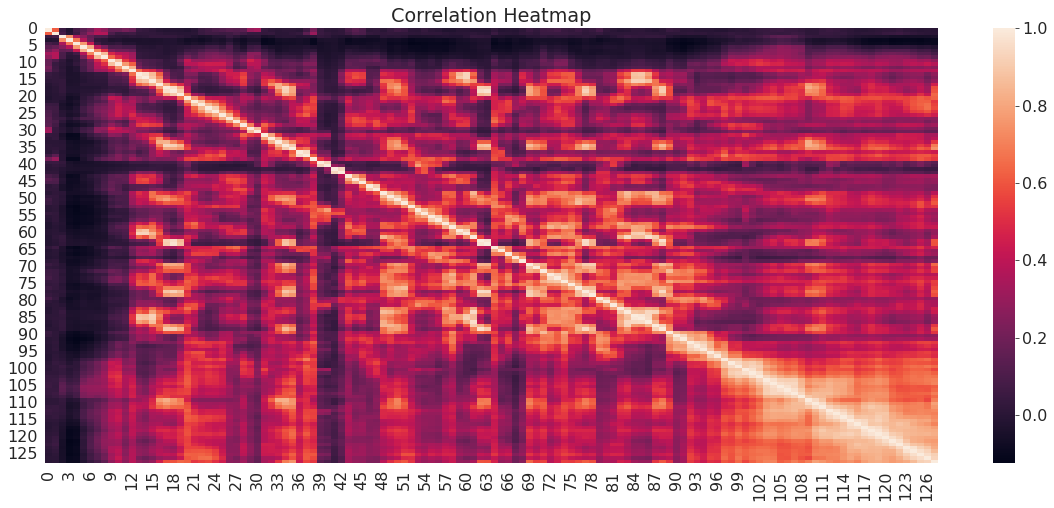

In [ ]:
plt.figure(figsize=(20,8))
sns.heatmap(X.corr())
plt.title("Correlation Heatmap")
plt.show()

## Descriptive Stats: Mel Spectro Features

In [ ]:
X.describe()

0             1             2             3             4    \
count  3.840000e+02  3.840000e+02  3.840000e+02  3.840000e+02  3.840000e+02   
mean   7.171435e-02  1.837096e-03  1.106939e-03  5.793375e-03  2.163532e-02   
std    3.893327e-01  1.391667e-02  2.955900e-03  1.338348e-02  4.242149e-02   
min    2.903162e-07  3.853062e-07  2.046970e-07  1.171699e-07  9.381065e-07   
25%    6.616908e-06  1.688524e-05  2.745901e-05  3.008635e-05  6.509914e-05   
50%    4.730992e-05  4.866670e-05  1.481191e-04  2.748633e-04  1.373312e-03   
75%    9.766504e-04  1.728168e-04  8.427886e-04  4.570220e-03  2.012341e-02   
max    4.724489e+00  2.377696e-01  2.991528e-02  9.020986e-02  3.137998e-01   

              5           6           7           8           9    ...  \
count  384.000000  384.000000  384.000000  384.000000  384.000000  ...   
mean     0.053416    0.068766    0.111469    0.156133    0.180760  ...   
std      0.104497    0.127508    0.202730    0.302572    0.386692  ...   
min      0.000007    0.000012    0.000026    0.000060    0.000047  ...   
25%      0.000297    0.002016    0.007536    0.014348    0.014195  ...   
50%      0.007932    0.015066    0.029681    0.044347    0.050517  ...   
75%      0.058789    0.066175    0.116954    0.158515    0.143143  ...   
max      0.799788    0.794558    1.353338    2.453658    3.570761  ...   

                118           119           120           121           122  \
count  3.840000e+02  3.840000e+02  3.840000e+02  3.840000e+02  3.840000e+02   
mean   4.162536e-04  4.078645e-04  4.309980e-04  4.414879e-04  4.429785e-04   
std    9.634448e-04  9.464574e-04  1.006204e-03  9.832070e-04  9.798486e-04   
min    7.234301e-08  7.852687e-08  1.283264e-07  1.104915e-07  1.165753e-07   
25%    1.667368e-05  2.077750e-05  2.136013e-05  2.109285e-05  2.188050e-05   
50%    1.091522e-04  1.078989e-04  1.019502e-04  1.177724e-04  1.111805e-04   
75%    3.711453e-04  3.751860e-04  3.976971e-04  3.909186e-04  3.758902e-04   
max    9.174547e-03  1.035824e-02  9.687290e-03  7.993858e-03  7.979555e-03   

                123           124           125           126           127  
count  3.840000e+02  3.840000e+02  3.840000e+02  3.840000e+02  3.840000e+02  
mean   4.466085e-04  3.044100e-04  9.362921e-05  9.165861e-06  1.523056e-07  
std    1.038891e-03  7.329258e-04  2.185443e-04  2.391105e-05  4.037155e-07  
min    2.434005e-07  1.469310e-07  3.401276e-08  5.073780e-09  1.186192e-10  
25%    2.009556e-05  1.361849e-05  4.222775e-06  4.111527e-07  6.217632e-09  
50%    8.985768e-05  6.412901e-05  1.920936e-05  1.703081e-06  2.990461e-08  
75%    3.750689e-04  2.502647e-04  7.304025e-05  7.147704e-06  1.122504e-07  
max    9.302646e-03  7.473094e-03  2.261650e-03  3.066632e-04  4.481485e-06  

[8 rows x 128 columns]

## Feature Scale: Mel Spectro Features
- The scale across all the 128 features is different therefore we need to standardize our feature inputs

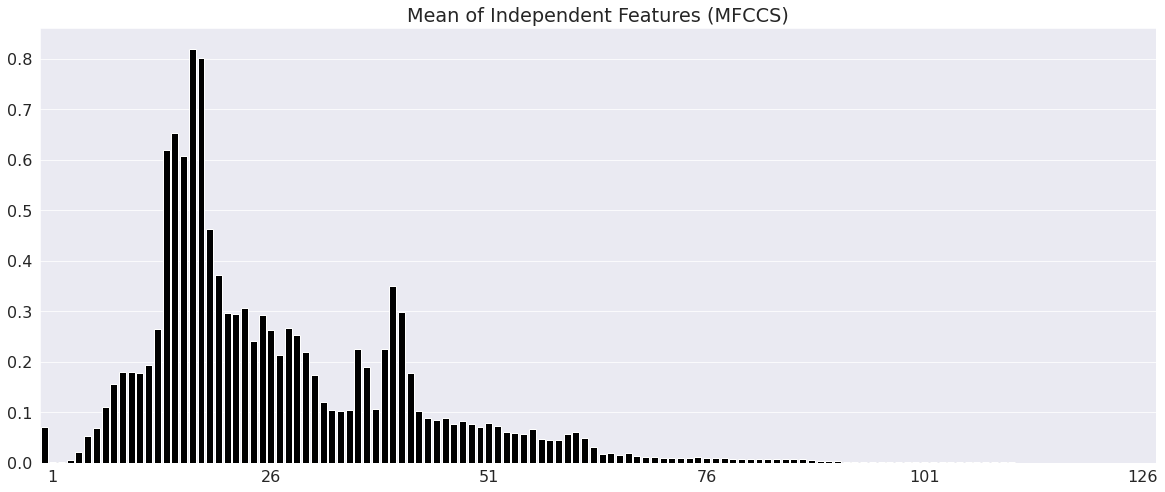

In [ ]:
sns.barplot(x=X.columns,y=X.mean(axis=0),color='black')
plt.title("Mean of Independent Features (MFCCS)")
plt.xticks(ticks=list(range(1,129,25)))
plt.show()

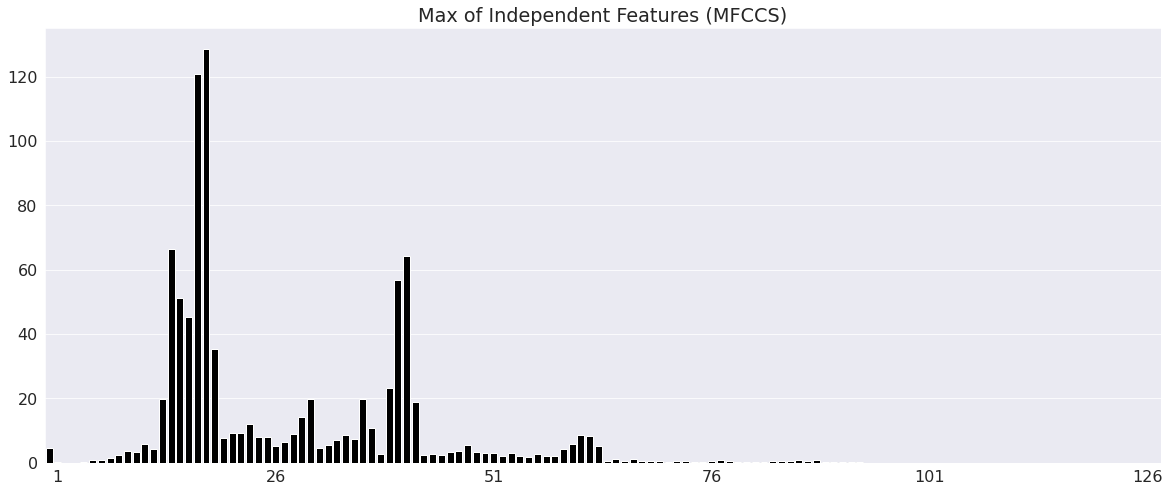

In [ ]:
sns.barplot(x=X.columns,y=X.max(axis=0),color='black')
plt.title("Max of Independent Features (MFCCS)")
plt.xticks(ticks=list(range(1,129,25)))
plt.show()

## Model 2: Classification Report

In [ ]:
scores, cmatrix = LogisticRegressionPipeline(X,y)

Training Performance
              precision    recall  f1-score   support

       happy       0.91      0.69      0.79       154
         sad       0.75      0.93      0.83       153

    accuracy                           0.81       307
   macro avg       0.83      0.81      0.81       307
weighted avg       0.83      0.81      0.81       307

-----------------------------------------
Test Performance
              precision    recall  f1-score   support

       happy       0.73      0.50      0.59        38
         sad       0.63      0.82      0.71        39

    accuracy                           0.66        77
   macro avg       0.68      0.66      0.65        77
weighted avg       0.68      0.66      0.65        77

-----------------------------------------
5-Folds Scores:  [0.67532468 0.74025974 0.67532468 0.72727273 0.71052632]
-----------------------------------------
5-Folds Average Score:  0.7057416267942583


<AxesSubplot:>

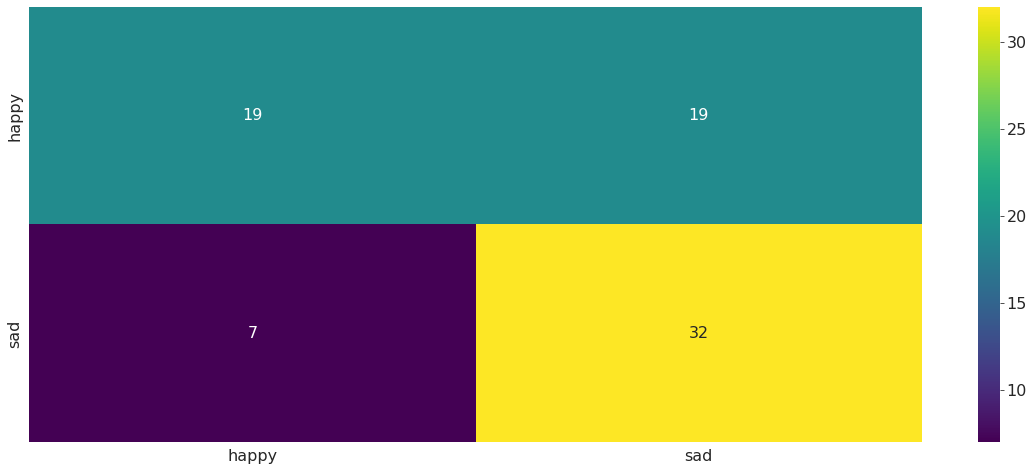

In [ ]:
sns.heatmap(cmatrix,annot=True,fmt='.3g',cmap='viridis',xticklabels=['happy','sad'],yticklabels=['happy','sad'])

## Model Summary
- The performance across the 5 folds is relatively stable to Model 1
- The mean accuracy is lower due to the same reason

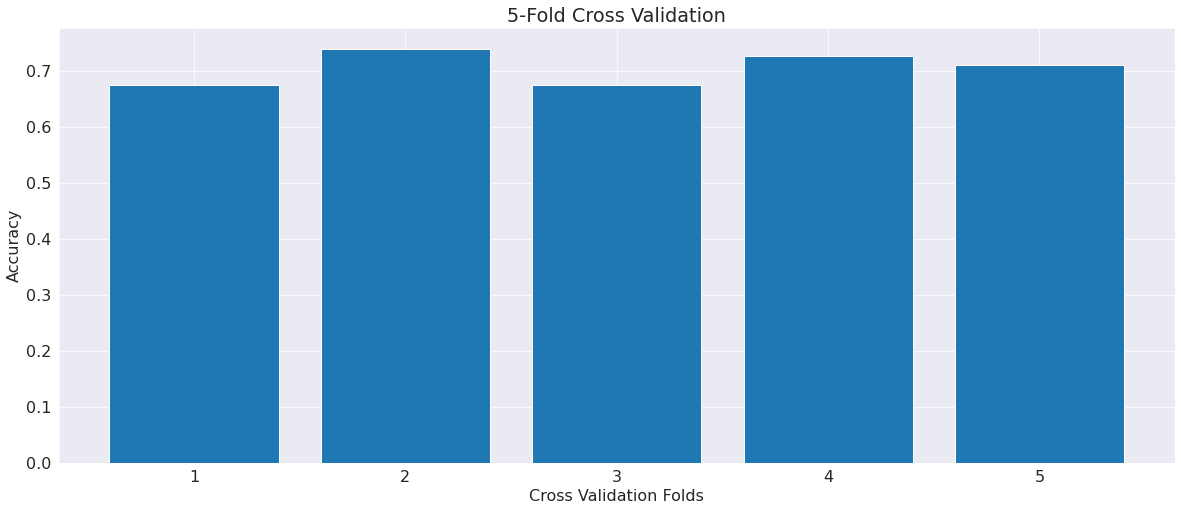

In [ ]:
plt.bar(x=list(range(1,6)),height=scores)
plt.xlabel("Cross Validation Folds")
plt.ylabel("Accuracy")
plt.title("5-Fold Cross Validation")
plt.show()

## Inference
- MFCCs are better features in comparison to Mel Spectrograms
- Model 2 is more stable in terms of the test accuracies but it also faces more overfit than Model 1
- Therefore as for now due to relatively better performance (individual accuracies across 5 folds) and lesser overfit Model 1 would be a better choice over Model 2